In [1]:
# Network/data is small enough that running on GPU slows training down
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

https://baseballsavant.mlb.com/csv-docs

https://fivethirtyeight.com/features/mlbs-hit-tracking-tool-misses-a-lot-of-hits/

- Player ID map
https://www.smartfantasybaseball.com/tools/

- stats
http://www.seanlahman.com/baseball-archive/statistics/

# Load statcast data

In [2]:
import pandas as pd

df = pd.read_csv('./statcast-2019-04-10.csv')
df.shape

/Users/dgates/venvs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(620579, 90)

In [3]:
df = df[df.game_year == 2018]
df.shape

(620560, 90)

In [4]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone
0,115.0,7.0,BAL,-10.4412,28.4190,-15.7096,0.0,0.0,3.0,592122.0,NaN,NaN,NaN,Tyler Austin strikes out swinging.,swinging_strike,90.722,NaN,NaN,NaN,strikeout,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,2.0,3.0,NYY,Standard,14.0,Bot,0.0,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,-0.7285,1.3626,4-Seam Fastball,3.0,FF,542960.0,542960.0,0.4224,3.4716,Brad Brach,7.0,3.0,7.0,3.0,5.839,-2.5964,54.6608,6.1537,91.7,2195.0,NaN,NaN,R,2.0,NaN,1.4472,3.2454,NaN,NaN,S,NaN,9.0707,-133.0662,-3.7404,1.0,0.0,12.0
1,115.0,7.0,BAL,-10.1062,29.7698,-9.9198,NaN,0.0,3.0,592122.0,NaN,NaN,NaN,NaN,foul,90.970,NaN,NaN,NaN,NaN,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,NYY,Standard,14.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,-0.6601,1.7870,4-Seam Fastball,2.0,FF,542960.0,542960.0,0.9707,2.5324,Brad Brach,7.0,3.0,7.0,3.0,5.781,-2.6948,54.7186,6.0787,92.3,2157.0,NaN,NaN,R,1.0,NaN,1.5890,3.4670,NaN,NaN,S,NaN,10.5851,-133.7651,-6.8526,NaN,NaN,12.0
2,115.0,7.0,BAL,-7.6452,30.1096,-10.5460,NaN,0.0,3.0,592122.0,NaN,NaN,NaN,NaN,called_strike,91.006,NaN,NaN,NaN,NaN,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,NYY,Standard,14.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,-0.5382,1.7198,4-Seam Fastball,1.0,FF,542960.0,542960.0,-0.9484,2.3415,Brad Brach,7.0,3.0,7.0,3.0,5.521,-2.8473,54.9783,6.1860,92.6,2265.0,NaN,NaN,R,0.0,NaN,1.6351,3.4636,NaN,NaN,S,NaN,5.8862,-134.4473,-7.4873,NaN,NaN,13.0
3,114.0,7.0,BAL,1.4834,24.1554,-28.0396,0.0,2.0,3.0,591720.0,line_drive,NaN,NaN,Ronald Torreyes lines out to second baseman Jo...,hit_into_play,83.781,NaN,0.458,0.406,field_out,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,144.14,135.76,160.0,4.0,3.0,NYY,Standard,14.0,Bot,0.0,18.0,65.1,2.0,Strategic,NaN,NaN,NaN,1.0,R,0.3480,0.3493,Slider,5.0,SL,542960.0,542960.0,1.3797,1.4883,Brad Brach,7.0,3.0,7.0,3.0,5.385,-3.3153,55.1144,5.9143,85.4,2590.0,NaN,NaN,R,2.0,NaN,1.2260,3.1146,NaN,NaN,X,NaN,10.1633,-123.7968,-4.6843,1.0,0.0,14.0
4,114.0,7.0,BAL,-8.2223,30.6771,-10.1566,NaN,2.0,3.0,591720.0,NaN,NaN,NaN,NaN,called_strike,90.912,NaN,NaN,NaN,NaN,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,NYY,Standard,14.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,1.0,R,-0.5107,1.7237,4-Seam Fastball,4.0,FF,542960.0,542960.0,0.7218,1.6812,Brad Brach,7.0,3.0,7.0,3.0,5.824,-2.7254,54.6751,6.1289,92.4,2382.0,NaN,NaN,R,1.0,NaN,1.4243,3.0535,NaN,NaN,S,NaN,9.7326,-133.7480,-8.9756,NaN,NaN,9.0


In [5]:
with pd.option_context('display.max_columns', None):
    display(df[df.ax.isnull()].head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone
101,89.0,3.0,BAL,NaN,NaN,NaN,0.0,0.0,3.0,592122.0,NaN,NaN,NaN,"Umpire reviewed (home-plate collision), call o...",ball,90.054,NaN,NaN,NaN,other_out,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,3.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,30.0,2.0,3.0,NYY,Standard,11.0,Bot,0.0,4.0,44.9,NaN,Standard,NaN,591720.0,544369.0,2.0,R,NaN,NaN,Slider,3.0,SL,571710.0,571710.0,NaN,NaN,Mychal Givens,3.0,3.0,3.0,3.0,6.317,NaN,NaN,NaN,90.5,2520.0,NaN,NaN,R,2.0,NaN,1.6142,3.3597,NaN,NaN,B,NaN,NaN,NaN,NaN,0.0,0.0,NaN
112,85.0,3.0,BAL,NaN,NaN,NaN,0.0,3.0,3.0,544369.0,NaN,NaN,NaN,Didi Gregorius walks.,ball,87.038,NaN,NaN,NaN,walk,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,3.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,NYY,Standard,11.0,Bot,0.0,NaN,NaN,NaN,Strategic,NaN,NaN,NaN,0.0,R,NaN,NaN,Changeup,8.0,CH,571710.0,571710.0,NaN,NaN,Mychal Givens,3.0,3.0,3.0,3.0,6.216,NaN,NaN,NaN,87.4,2181.0,NaN,NaN,L,2.0,NaN,1.5540,3.4133,NaN,NaN,B,NaN,NaN,NaN,NaN,1.0,0.7,NaN
351,70.0,4.0,CHC,NaN,NaN,NaN,NaN,1.0,4.0,605170.0,NaN,NaN,NaN,NaN,foul,92.422,NaN,NaN,NaN,NaN,444489.0,444489.0,519346.0,519299.0,543768.0,606115.0,460075.0,456715.0,570267.0,4.0,2018-04-06,529510.0,R,2018.0,NaN,NaN,227.0,NaN,4.0,MIL,Strategic,8.0,Top,NaN,33.0,78.8,NaN,Standard,NaN,NaN,NaN,1.0,R,NaN,NaN,Sinker,5.0,SI,458006.0,458006.0,NaN,NaN,Matt Albers,4.0,4.0,4.0,4.0,6.269,NaN,NaN,NaN,92.7,2235.0,NaN,NaN,L,2.0,180407_032038,1.0741,3.3206,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1605,33.0,1.0,SD,NaN,NaN,NaN,NaN,0.0,1.0,435263.0,NaN,NaN,NaN,NaN,ball,NaN,NaN,NaN,NaN,NaN,595978.0,595978.0,543333.0,641319.0,570799.0,520471.0,517369.0,622534.0,592669.0,1.0,2018-04-06,529515.0,R,2018.0,NaN,NaN,NaN,NaN,1.0,HOU,Infield shift,4.0,Bot,NaN,NaN,NaN,NaN,Strategic,594828.0,NaN,NaN,0.0,R,NaN,NaN,NaN,1.0,NaN,606131.0,606131.0,NaN,NaN,Luis Perdomo,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,0.0,180407_012913,1.6756,3.3724,NaN,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3180,62.0,7.0,SF,NaN,NaN,NaN,0.0,1.0,0.0,605486.0,ground_ball,NaN,NaN,"Cory Spangenberg grounds out, second baseman J...",hit_into_play,NaN,NaN,0.066,0.06,field_out,457763.0,457763.0,474832.0,605412.0,446334.0,543063.0,452254.0,453923.0,457705.0,7.0,2018-04-12,529595.0,R,2018.0,151.42,154.69,NaN,4.0,0.0,SD,Standard,7.0,Bot,0.0,-21.0,82.9,2.0,Standard,NaN,NaN,NaN,1.0,R,NaN,NaN,NaN,4.0,NaN,608717.0,608717.0,NaN,NaN,Chris Stratton,7.0,0.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L,2.0,NaN,1.2105,2.9690,NaN,NaN,X,NaN,NaN,NaN,NaN,1.0,0.0,NaN


In [6]:
# df = df[df.type.ne('B')]
df = df[~df.game_pk.isnull()]
df.shape

(620560, 90)

## Remove at-bats due to fielding influence

In [7]:
invalid_events = {
    'catcher_interf',
    'fielders_choice_out',
    'field_error',
    'fielders_choice',
    'batter_interference',
}
invalid_at_bats = df.loc[:, ['game_pk', 'at_bat_number', 'events']]
invalid_at_bats['remove'] = invalid_at_bats.events.isin(invalid_events)
invalid_at_bats = invalid_at_bats.groupby(['game_pk', 'at_bat_number']).remove.max()

In [8]:
invalid_at_bats.sum()

1764

In [9]:
invalid_at_bats = pd.DataFrame(invalid_at_bats[~invalid_at_bats])
df = df.merge(invalid_at_bats, left_on=invalid_at_bats.index.names, right_index=True)
df.shape

(614471, 91)

# Load player IDs

In [10]:
player_ids = pd.read_excel('~/Downloads/SFBB-Player-ID-Map.xlsx')
player_ids.shape

(2177, 42)

In [11]:
with pd.option_context('display.max_columns', None):
    display(player_ids.head())

,IDPLAYER,PLAYERNAME,BIRTHDATE,FIRSTNAME,LASTNAME,TEAM,LG,POS,IDFANGRAPHS,FANGRAPHSNAME,MLBID,MLBNAME,CBSID,CBSNAME,RETROID,BREFID,NFBCID,NFBCNAME,ESPNID,ESPNNAME,KFFLNAME,DAVENPORTID,BPID,YAHOOID,YAHOONAME,MSTRBLLNAME,BATS,THROWS,FANTPROSNAME,LASTCOMMAFIRST,ROTOWIREID,FANDUELNAME,FANDUELID,DRAFTKINGSNAME,OTTONEUID,HQID,RAZZBALLNAME,FANTRAXID,FANTRAXNAME,ROTOWIRENAME,ALLPOS,NFBCLASTFIRST
0,aardsda01,David Aardsma,1981-12-27,David,Aardsma,NaN,NaN,P,1902,David Aardsma,430911.0,David Aardsma,479025.0,David Aardsma,aardd001,aardsda01,7307.0,David Aardsma,5933.0,David Aardsma,NaN,AARDSMA19811227A,45369.0,7307.0,David Aardsma,"Aardsma, David",R,R,David Aardsma,"Aardsma, David",7633.0,NaN,NaN,David Aardsma,4362.0,NaN,David Aardsma,NaN,NaN,David Aardsma,P,"Aardsma, David"
1,abadfe01,Fernando Abad,1985-12-17,Fernando,Abad,NaN,NaN,P,4994,Fernando Abad,472551.0,Fernando Abad,1723564.0,Fernando Abad,abadf001,abadfe01,8767.0,Fernando Abad,30417.0,Fernando Abad,NaN,ABAD19851217A,49706.0,8767.0,Fernando Abad,"Abad, Fernando",L,L,Fernando Abad,"Abad, Fernando",11285.0,Fernando Abad,12453.0,Fernando Abad,7372.0,3556.0,Fernando Abad,01viz,"Abad, Fernando",Fernando Abad,P,"Abad, Fernando"
2,abreual01,Albert Abreu,1995-09-26,Albert,Abreu,NYY,AL,P,sa828366,Albert Abreu,656061.0,Albert Abreu,2211792.0,Albert Abreu,NaN,abreual01,10546.0,Albert Abreu,36041.0,NaN,NaN,NaN,104651.0,NaN,NaN,"Abreu, Albert",R,R,Albert Abreu,"Abreu, Albert",14063.0,NaN,NaN,NaN,NaN,5762.0,Albert Abreu,NaN,NaN,Albert Abreu,P,"Abreu, Albert"
3,abreubo01,Bobby Abreu,1974-03-11,Bobby,Abreu,NaN,NaN,OF,945,Bobby Abreu,110029.0,Bobby Abreu,7367.0,Bobby Abreu,abreb001,abreubo01,5698.0,Bobby Abreu,3537.0,Bobby Abreu,Bobby Abreu,ABREU19740311A,650.0,5698.0,Bobby Abreu,"Abreu, Bobby",L,R,Bobby Abreu,"Abreu, Bobby",NaN,NaN,NaN,NaN,8984.0,NaN,Bobby Abreu,NaN,NaN,NaN,OF,"Abreu, Bobby"
4,abreujo02,Jose Abreu,1987-01-29,Jose,Abreu,CHW,AL,1B,15676,Jose Abreu,547989.0,Jose Abreu,2106364.0,Jose Abreu,abrej003,abreujo02,9540.0,Jose Abreu,33095.0,Jose Abreu,Jose Abreu,ABREUcubaJ01,102005.0,9540.0,Jose Abreu,"Abreu, Jose",R,R,Jose Abreu,"Abreu, Jose",11341.0,Jose Abreu,49523.0,Jose Abreu,18286.0,4515.0,Jose Abreu,02i2e,"Abreu, Jose","Abreu, Jose",1B,"Abreu, Jose"


In [12]:
player_ids = player_ids[['MLBID', 'MLBNAME', 'IDPLAYER']]
batter_ids = player_ids.copy()
batter_ids.columns = [f'batter_{c.lower()}' for c in batter_ids.columns]
pitcher_ids = player_ids.copy()
pitcher_ids.columns = [f'pitcher_{c.lower()}' for c in pitcher_ids.columns]

In [13]:
batter_ids = batter_ids[~batter_ids.batter_mlbid.isnull()]
pitcher_ids = pitcher_ids[~pitcher_ids.pitcher_mlbid.isnull()]

In [14]:
assert len(batter_ids) == batter_ids.batter_mlbid.nunique(), f'{len(batter_ids)} != {batter_ids.batter_mlbid.nunique()}'

In [15]:
assert len(pitcher_ids) == pitcher_ids.pitcher_mlbid.nunique(), f'{len(pitcher_ids)} != {pitcher_ids.pitcher_mlbid.nunique()}'

## Blend IDs in with statcast data

In [16]:
df = df.merge(batter_ids, left_on='batter', right_on='batter_mlbid', how='left')
df = df.merge(pitcher_ids, left_on='pitcher', right_on='pitcher_mlbid', how='left')
df.shape

(614471, 97)

In [17]:
with pd.option_context('display.max_columns', None):
    display(df[df.batter_mlbname.isnull()].sample(20).head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone,remove,batter_mlbid,batter_mlbname,batter_idplayer,pitcher_mlbid,pitcher_mlbname,pitcher_idplayer
169482,30.0,2.0,TOR,-17.3250,26.1611,-24.1977,NaN,0.0,2.0,620446.0,NaN,NaN,NaN,NaN,ball,91.055,NaN,NaN,NaN,NaN,519023.0,519023.0,527038.0,452678.0,408314.0,642708.0,607043.0,501571.0,457803.0,1.0,2018-05-15,530038.0,R,2018.0,NaN,NaN,NaN,NaN,1.0,NYM,Standard,4.0,Top,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,1.0,R,-1.4190,0.5703,Changeup,2.0,CH,592789.0,592789.0,-0.4388,1.5502,Noah Syndergaard,2.0,2.0,1.0,1.0,6.620,-0.5493,53.8793,6.3834,90.3,1735.0,NaN,NaN,L,1.0,NaN,1.6544,3.5222,NaN,NaN,B,NaN,3.3427,-131.3819,-7.3800,NaN,NaN,7.0,False,NaN,NaN,NaN,592789.0,Noah Syndergaard,syndeno01
612302,32.0,0.0,MIA,6.1781,25.2158,-20.4075,NaN,2.0,1.0,607732.0,NaN,NaN,NaN,NaN,foul,80.592,NaN,NaN,NaN,NaN,592407.0,592407.0,598284.0,516770.0,605119.0,500743.0,621573.0,621446.0,642423.0,0.0,2018-09-08,531533.0,R,2018.0,NaN,NaN,155.0,NaN,1.0,PIT,Standard,4.0,Bot,NaN,51.0,60.6,NaN,Standard,591741.0,605137.0,NaN,2.0,L,0.6267,1.1971,Changeup,4.0,CH,612672.0,612672.0,1.4227,1.8178,Wei-Yin Chen,0.0,1.0,0.0,1.0,5.949,1.7388,54.5498,5.8692,81.5,1356.0,NaN,NaN,R,1.0,180908_182141,1.5509,3.2449,NaN,NaN,S,NaN,-1.8845,-118.5398,-4.6705,NaN,NaN,14.0,False,NaN,NaN,NaN,612672.0,Wei-Yin Chen,chenwe02
403590,58.0,2.0,TOR,-10.6577,21.8896,-24.7543,NaN,0.0,2.0,620446.0,NaN,NaN,NaN,NaN,ball,84.282,NaN,NaN,NaN,NaN,521692.0,521692.0,656811.0,594011.0,641531.0,609275.0,460086.0,593160.0,593528.0,6.0,2018-08-16,531232.0,R,2018.0,NaN,NaN,NaN,NaN,6.0,KC,Standard,7.0,Top,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,0.0,R,-0.9334,0.6649,Changeup,3.0,CH,641838.0,641838.0,0.4253,1.2202,Kevin McCarthy,2.0,2.0,6.0,6.0,6.193,-1.8400,54.3062,5.6347,84.2,1565.0,NaN,NaN,L,2.0,NaN,1.5379,3.4648,NaN,NaN,B,NaN,7.0747,-122.3912,-5.2041,NaN,NaN,14.0,False,NaN,NaN,NaN,NaN,NaN,NaN
452298,47.0,5.0,ATL,6.4828,30.3441,-12.3400,NaN,2.0,0.0,592680.0,NaN,NaN,NaN,NaN,foul,91.464,NaN,NaN,NaN,NaN,452095.0,452095.0,518692.0,645277.0,622666.0,518586.0,660670.0,542255.0,455976.0,5.0,2018-08-23,531318.0,R,2018.0,NaN,NaN,168.0,NaN,0.0,MIA,Standard,6.0,Bot,NaN,34.0,62.0,NaN,Standard,NaN,NaN,NaN,0.0,L,0.3904,1.5322,4-Seam Fastball,4.0,FF,656794.0,656794.0,-0.7212,2.3101,Sean Newcomb,5.0,0.0,5.0,0.0,5.999,2.1860,54.5016,6.6406,92.4,2109.0,NaN,NaN,R,1.0,180824_011112,1.6010,3.4900,NaN,NaN,S,NaN,-8.1735,-134.0531,-8.3784,NaN,NaN,4.0,False,NaN,NaN,NaN,656794.0,Sean Newcomb,newcose01
313680,37.0,3.0,LAD,-6.1133,24.7996,-16.2826,NaN,2.0,1.0,621044.0,NaN,NaN,NaN,NaN,called_strike,90.645,NaN,NaN,NaN,NaN,518735.0,518735.0,571970.0,571771.0,592518.0,621035.0,592626.0,641355.0,657077.0,3.0,2018-07-24,530922.0,R,2018.0,NaN,NaN,NaN,NaN,1.0,PHI,Standard,5.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,1.0,R,-0.4451,1.2617,4-Seam Fastball,3.0,FF,628317.0,628317.0,-0.5057,1.3833,Kenta Maeda,3.0,1.0,3.0,1.0,6.107,-2.1228,54.3960,5.6757,90.6,2121.0,NaN,NaN,L,0.0,180725_010041,1.6386,3.6415,NaN,NaN,S,NaN,4.9565,-131.7403,-7.4789,NaN,NaN,13.0,False,NaN,NaN,NaN,628

# Load statistics

## Batting

In [18]:
batting_stats = pd.read_csv('baseballdatabank-2019.2/core/Batting.csv')
batting_stats = batting_stats.merge(batter_ids, left_on='playerID', right_on='batter_idplayer')
batting_stats = batting_stats[batting_stats.yearID == 2018]
batting_stats.shape

(1205, 25)

In [19]:
# players are represented multiple times when there is a trade
batting_stats = batting_stats.groupby('batter_mlbid', as_index=False)[[
    'H', 'BB', 'HBP', '2B', '3B', 'HR', 'SF', 'AB'
]].sum()
batting_stats['1B'] = batting_stats.H - (batting_stats['2B'] - batting_stats['3B'] - batting_stats['HR'])
batting_stats.shape

(1071, 10)

In [20]:
stats = batting_stats  # alias
stats['obp'] = (stats['H'] + stats['BB'] + stats['HBP']) / (stats['AB'] + stats['BB'] + stats['SF'] + stats['HBP'])
stats['slg'] = (stats['1B'] + (2*stats['2B']) + (3*stats['3B']) + (4*stats['HR'])) / stats.AB
stats['ops'] = stats.obp + stats.slg
stats['obp'].describe(), stats.slg.describe(), stats.ops.describe()

(count    823.000000
 mean       0.244371
 std        0.144940
 min        0.000000
 25%        0.161528
 50%        0.285714
 75%        0.330852
 max        1.000000
 Name: obp, dtype: float64, count    823.000000
 mean       0.345414
 std        0.246788
 min        0.000000
 25%        0.125000
 50%        0.388889
 75%        0.504371
 max        2.000000
 Name: slg, dtype: float64, count    823.000000
 mean       0.589784
 std        0.373841
 min        0.000000
 25%        0.312091
 50%        0.684118
 75%        0.835459
 max        3.000000
 Name: ops, dtype: float64)

## Pitching

In [21]:
pitching_stats = pd.read_csv('baseballdatabank-2019.2/core/Pitching.csv')
pitching_stats = pitching_stats[pitching_stats.yearID == 2018]
pitching_stats = pitching_stats.merge(pitcher_ids, left_on='playerID', right_on='pitcher_idplayer')
pitching_stats.shape

(657, 33)

In [22]:
pitching_stats['IP'] = pitching_stats.IPouts / 3

In [23]:
pitching_stats = pitching_stats.groupby([
    'pitcher_mlbid',
], as_index=False)[['IP', 'BB', 'H', 'ER']].sum()
pitching_stats.shape

(581, 5)

In [24]:
pitching_stats['ERA'] = ((pitching_stats.ER / pitching_stats.IP) * 9 )
pitching_stats['WHIP'] = (pitching_stats.BB + pitching_stats.H) / pitching_stats.IP

# Feature engineering

## Create target variable

Did the at-bat result in a hit or walk?

In [25]:
df.events.unique()

array(['strikeout', nan, 'field_out', 'home_run', 'sac_bunt', 'single',
       'walk', 'other_out', 'force_out', 'grounded_into_double_play',
       'double', 'double_play', 'hit_by_pitch', 'triple', 'sac_fly',
       'strikeout_double_play', 'pickoff_caught_stealing_2b',
       'caught_stealing_2b', 'pickoff_1b', 'caught_stealing_3b',
       'caught_stealing_home', 'triple_play', 'sac_fly_double_play',
       'pickoff_2b', 'sac_bunt_double_play', 'pickoff_3b',
       'pickoff_caught_stealing_3b', 'pickoff_caught_stealing_home',
       'run'], dtype=object)

In [26]:
import numpy as np
target_events = [
    'single',
    'double',
    'triple',
    'home_run',
    'walk',
]
target_events = {event: i for i, event in enumerate(target_events, start=1)}
df['target'] = df.events.map(target_events).fillna(0).astype(int)

## Create auxillary targets

In [27]:
auxillary_targets = [
    'hit_distance_sc',
    'launch_speed',
    'launch_angle',
]
for t in auxillary_targets:
    df[t] = (df[t] - df[t].mean()) / df[t].std()
df['auxillary_targets'] = df[auxillary_targets].fillna(0).values.tolist()

In [28]:
import numpy as np
np.stack(df.iloc[:10]['auxillary_targets'])

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.02077875, -1.21074835,  0.05853688],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 1.01482044,  1.2871471 , -0.11390143],
       [ 0.        ,  0.        ,  0.        ]])

# Who's on first

Or rather, is anyone on first.

In [29]:
df['runner_on_first'] = (~df.on_1b.isnull()).astype(int)
df['runner_on_second'] = (~df.on_2b.isnull()).astype(int)
df['runner_on_third'] = (~df.on_3b.isnull()).astype(int)

In [30]:
total_pitches = df.loc[:, ['game_pk', 'at_bat_number', 'pitch_number', 'pitcher']]
total_pitches['counter'] = 1

# How many pitches has the pitcher thrown

In [31]:
total_pitches.sort_values(['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'], inplace=True)
total_pitches['total_pitch_number'] = total_pitches.groupby([
    'game_pk', 'pitcher'
], as_index=False).counter.cumsum()
with pd.option_context('display.max_rows', None):
    display(total_pitches.head(100))

,game_pk,at_bat_number,pitch_number,pitcher,counter,total_pitch_number
30835,529406.0,1.0,1.0,502042.0,1,1
30812,529406.0,2.0,1.0,502042.0,1,2
30811,529406.0,2.0,2.0,502042.0,1,3
30810,529406.0,2.0,3.0,502042.0,1,4
30715,529406.0,3.0,1.0,502042.0,1,5
30714,529406.0,3.0,2.0,502042.0,1,6
30713,529406.0,3.0,3.0,502042.0,1,7
30712,529406.0,3.0,4.0,502042.0,1,8
30711,529406.0,3.0,5.0,502042.0,1,9
30710,529406.0,3.0,6.0,502042.0,1,10


In [32]:
df = df.merge(total_pitches, on=['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'])

# Create batter IDs to be embedded

In [33]:
import numpy as np
eligible_batters = batting_stats[batting_stats.AB > 100].batter_mlbid
df['batter_id'] = np.where(df.batter.isin(eligible_batters), df.batter, 0)

In [34]:
df[['batter_id', 'batter_mlbname']].drop_duplicates().shape

(831, 2)

## Create pitcher IDs to be embedded

In [35]:
eligible_pitchers = pitching_stats[pitching_stats.IP > 20].pitcher_mlbid
df['pitcher_id'] = np.where(df.pitcher.isin(eligible_pitchers), df.pitcher, 0)
len(eligible_pitchers), df.pitcher_id.nunique()

(451, 452)

# Define features

In [36]:
numeric_features = [
    'bat_score',  # these are pre-pitch
    'fld_score',  # these are pre-pitch
    'balls',
    'strikes',
    'outs_when_up',
    'pitch_number',
    'inning',
    'total_pitch_number',
    'at_bat_number',
    'ax',
    'ay',
    'az',
    'pfx_x',
    'pfx_z',
    'vx0',
    'vy0',
    'vz0',
    'release_speed',
    'release_spin_rate',
    'release_pos_x',
    'release_pos_y',
    'plate_x',
    'plate_z',
    'sz_top',
    'sz_bot',
]

categorical_features = [
    'if_fielding_alignment',
    'of_fielding_alignment',
    'inning_topbot',  # home field advantage
    'pitch_name',
    'zone',
    'pitcher_id',
    'batter_id',  # mapping of batters with less than 100 AB to 0
    'game_type',
    'stand',  # for batter
    'runner_on_first',
    'runner_on_second',
    'runner_on_third',
    'away_team',
    'home_team',
    'p_throws',
]

target = 'target'

# Linear model

In [37]:
import sklearn

class GetDummies(sklearn.base.TransformerMixin):
    """Fast one-hot-encoder that makes use of pandas.get_dummies() safely
    on train/test splits.
    """
    def __init__(self, dtypes=None):
        self.input_columns = None
        self.final_columns = None
        if dtypes is None:
            dtypes = [object, 'category']
        self.dtypes = dtypes

    def fit(self, X, y=None):
        self.input_columns = list(X.select_dtypes(self.dtypes).columns)
        X = pd.get_dummies(X, columns=self.input_columns)
        self.final_columns = X.columns
        return self
        
    def transform(self, X, y=None):
        X = pd.get_dummies(X, columns=self.input_columns)
        X_columns = X.columns
        # if columns in X had values not in the data set used during
        # fit add them and set to 0
        missing = [c for c in self.final_columns if not c in X_columns]
        for c in missing:
            X[c] = 0
        # remove any new columns that may have resulted from values in
        # X that were not in the data set when fit
        return X[self.final_columns]
    
    def get_feature_names(self):
        return tuple(self.final_columns)


In [38]:
final_pitch = (df
    .sort_values(['game_pk', 'at_bat_number', 'pitch_number'])
    .groupby(['game_pk', 'at_bat_number'])
    .tail(1)
)
X = final_pitch[numeric_features + categorical_features]

y = np.zeros((len(X), len(target_events) + 1))
y[np.arange(len(y)), final_pitch[target].values] = 1
assert y.sum() == len(y)

In [39]:
y.mean(axis=0)

array([0.69543887, 0.1432353 , 0.0449559 , 0.00468967, 0.03069601,
       0.08098426])

In [40]:
X.isnull().any(axis=1).mean()

0.022054799750563143

In [41]:
X, y = X[~X.isnull().any(axis=1)], y[~X.isnull().any(axis=1)]

In [42]:
get_dummies = GetDummies()
X_t = X.copy()
for f in categorical_features:
    X_t[f] = X_t[f].astype(str)
X_t = get_dummies.fit_transform(X_t)

In [43]:
X_t.shape

(153688, 1008)

In [47]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
linear_model = Sequential()
linear_model.add(BatchNormalization())
linear_model.add(Dense(len(target_events) + 1, activation='softmax', name='y', input_dim=X_t.shape[-1]))
linear_model.compile(loss='categorical_crossentropy', optimizer='adam')
linear_model.fit(X_t.values, y, epochs=5)

Epoch 1/5
153688/153688 [==============================] - 14s 92us/step - loss: 0.8318
Epoch 2/5
153688/153688 [==============================] - 14s 88us/step - loss: 0.7863
Epoch 3/5
153688/153688 [==============================] - 13s 84us/step - loss: 0.7836
Epoch 4/5
153688/153688 [==============================] - 13s 84us/step - loss: 0.7818
Epoch 5/5
153688/153688 [==============================] - 13s 86us/step - loss: 0.7799


In [48]:
model_features = get_dummies.get_feature_names()
coefficients = linear_model.get_layer('y').get_weights()[0]

In [49]:
sorted([(f, c) for f, c in zip(model_features, coefficients[:, 0])], reverse=True, key=lambda x: abs(x[-1]))

[('balls', -0.3808374),
 ('strikes', 0.26638234),
 ('pitch_name_Pitch Out', 0.16896914),
 ('pitch_name_Knuckle Ball', -0.16782117),
 ('batter_id_0.0', 0.1633155),
 ('pitcher_id_541652.0', -0.12997231),
 ('pitch_name_Eephus', 0.12507293),
 ('home_team_CIN', -0.11664448),
 ('zone_13.0', 0.11543214),
 ('pitcher_id_647336.0', -0.11095205),
 ('pitcher_id_518617.0', -0.10885645),
 ('pitcher_id_430641.0', -0.10824131),
 ('release_spin_rate', 0.10743291),
 ('batter_id_519346.0', -0.10709635),
 ('pitcher_id_519443.0', -0.106895976),
 ('pitcher_id_453192.0', -0.10606367),
 ('batter_id_435064.0', 0.1045624),
 ('home_team_TEX', -0.10417422),
 ('pitcher_id_641771.0', -0.103870645),
 ('batter_id_572228.0', -0.101504564),
 ('sz_bot', -0.10115999),
 ('pitcher_id_595918.0', -0.09849566),
 ('pitcher_id_475054.0', 0.097377956),
 ('batter_id_572204.0', 0.096675105),
 ('pitcher_id_669203.0', 0.09626545),
 ('pitcher_id_571704.0', -0.09590267),
 ('pitcher_id_461872.0', -0.09549892),
 ('ay', 0.095449455),
 ('

In [52]:
feature_coefs = {feature: coef for feature, coef in zip(model_features, coefficients[:, 0])}
pitcher_coefs = {float(f.split('_')[-1]): c for f, c in feature_coefs.items() if 'pitcher' in f}
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
s = pitching_stats.copy().merge(pitchers, left_on='pitcher_mlbid', right_on='pitcher_id')
s['coef'] = s.pitcher_mlbid.map(pitcher_coefs)
s[s.IP > 100].sort_values('coef', ascending=False).head(10)

,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,pitcher_id,player_name,coef
185,543135.0,111.000000,20,105,47,3.810811,1.126126,543135.0,Nathan Eovaldi,0.085257
168,527054.0,175.666667,84,122,77,3.944972,1.172676,527054.0,Julio Teheran,0.078154
145,518774.0,155.000000,37,165,85,4.935484,1.303226,518774.0,Matt Harvey,0.078073
6,425844.0,207.666667,43,181,74,3.207063,1.078652,425844.0,Zack Greinke,0.076197
55,456034.0,176.000000,50,151,70,3.579545,1.142045,456034.0,David Price,0.074665
48,453286.0,220.666667,51,150,62,2.528701,0.910876,453286.0,Max Scherzer,0.073144
29,448306.0,204.666667,78,190,103,4.529316,1.309446,448306.0,James Shields,0.069119
116,502043.0,196.666667,79,177,79,3.615254,1.301695,502043.0,Kyle Gibson,0.069068
252,573186.0,102.333333,36,115,63,5.540717,1.475570,573186.0,Marcus Stroman,0.068536
399,625643.0,188.666667,75,165,82,3.911661,1.272085,625643.0,Reynaldo Lopez,0.063697


In [53]:
feature_coefs = {feature: coef for feature, coef in zip(model_features, coefficients[:, 0])}
pitcher_coefs = {float(f.split('_')[-1]): c for f, c in feature_coefs.items() if 'pitcher' in f}
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
s = pitching_stats.copy().merge(pitchers, left_on='pitcher_mlbid', right_on='pitcher_id')
s['coef'] = s.pitcher_mlbid.map(pitcher_coefs)
s[s.IP < 100].sort_values('coef', ascending=False).head(10)

,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,pitcher_id,player_name,coef
85,475054.0,50.333333,16,35,20,3.576159,1.013245,475054.0,Chaz Roe,0.097378
447,669203.0,38.000000,11,27,11,2.605263,1.000000,669203.0,Corbin Burnes,0.096265
44,453214.0,53.666667,26,41,16,2.683230,1.248447,453214.0,Steven Wright,0.085542
319,605240.0,51.333333,20,37,25,4.383117,1.110390,605240.0,Jace Fry,0.084342
365,608678.0,24.000000,8,27,12,4.500000,1.458333,608678.0,Dominic Leone,0.083613
378,621237.0,64.000000,29,42,17,2.390625,1.109375,621237.0,Jose Alvarado,0.083604
28,448281.0,45.000000,6,21,8,1.600000,0.600000,448281.0,Sean Doolittle,0.083216
68,458924.0,34.333333,16,26,14,3.669903,1.223301,458924.0,Jonny Venters,0.081662
217,553878.0,70.000000,24,63,21,2.700000,1.242857,553878.0,Felipe Vazquez,0.077999
97,489119.0,80.666667,27,71,23,2.566116,1.214876,489119.0,Wade Miley,0.077201


In [51]:
feature_coefs = {feature: coef for feature, coef in zip(model_features, coefficients[:, 1:].sum(axis=1))}
batter_coefs = {float(f.split('_')[-1]): c for f, c in feature_coefs.items() if 'batter' in f}
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
s = batting_stats.copy().merge(batters, left_on='batter_mlbid', right_on='batter_id')
s['coef'] = s.batter_mlbid.map(batter_coefs)
s.sort_values('coef', ascending=False).head(10)

,batter_mlbid,H,BB,HBP,2B,3B,HR,SF,AB,1B,obp,slg,ops,batter_id,batter_mlbname,coef
266,592885.0,187,68,7.0,34,7,36,2.0,574,196,0.402458,0.747387,1.149845,592885.0,Christian Yelich,-0.119223
413,660670.0,127,45,6.0,26,4,26,3.0,433,131,0.365503,0.690531,1.056034,660670.0,Ronald Acuna,-0.180547
288,595879.0,176,29,5.0,40,9,34,4.0,606,179,0.326087,0.696370,1.022457,595879.0,Javier Baez,-0.198649
121,502671.0,172,90,6.0,35,5,33,0.0,593,175,0.388970,0.661046,1.050015,502671.0,Paul Goldschmidt,-0.267168
312,605141.0,180,81,8.0,47,5,32,5.0,520,170,0.438111,0.782692,1.220803,605141.0,Mookie Betts,-0.269229
131,518586.0,80,21,4.0,18,2,12,1.0,296,76,0.326087,0.560811,0.886898,518586.0,Charlie Culberson,-0.272410
132,518614.0,83,64,2.0,22,4,13,7.0,349,78,0.353081,0.532951,0.886032,518614.0,Daniel Descalso,-0.278788
29,444482.0,164,48,4.0,25,5,30,2.0,560,174,0.351792,0.641071,0.992863,444482.0,David Peralta,-0.287654
378,641355.0,145,69,3.0,28,7,25,3.0,557,149,0.343354,0.585278,0.928633,641355.0,Cody Bellinger,-0.288069
325,606299.0,182,29,9.0,31,4,14,5.0,632,169,0.325926,0.473101,0.799027,606299.0,Jose Peraza,-0.292623


# Getting deeper

## Define an encoder

To map IDs to valid range for `keras` embedding layers

In [54]:
from sklearn.base import TransformerMixin

class Encoder(TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X):
        self.mappings = {
            feature: {v: i for i, v in enumerate(X[feature].unique())}
            for feature in X.columns
        }
        return self
    
    def transform(self, X):
        return {
            f'{feature}_input': X[feature].map(self.mappings[feature]).values
            for feature in X.columns
            if feature in self.mappings
        }

    def inverse_transform(self, X, feature):
        return X.map({v: k for k, v in self.mappings[feature].items()})
    
    def get_feature_dim(self, feature):
        return len(self.mappings[feature])

## Build batches for training

In [55]:
encoder = Encoder()
encoder.fit(df[categorical_features])

In [58]:
if True:
    sample_key = df[['game_pk', 'at_bat_number']].apply(lambda x: hash(tuple(x)) % 100, axis=1)
    df_sample = df[sample_key <= 10]
else:
    df_sample = df

In [59]:
df_sample.shape

(153611, 106)

Here we "featurize" each at-bat. In the following step we sort each at-bat by the number of pitches thrown and build the batches based on these groups so that we minimize padding during training.

In [60]:
from tqdm import tqdm_notebook as tqdm

df_sample.sort_values(['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)

groups = df_sample.groupby([
    'game_pk', 'at_bat_number'
], as_index=False)
groups = list(groups)
np.random.shuffle(groups)

X_train = []
y_train = []

def featurize_at_bat(group):
    (game_pk, at_bat_number), group_df = group
    x = encoder.transform(group_df[categorical_features])
    x['numeric_inputs'] = group_df[numeric_features].values
    
    y = np.zeros((len(target_events) + 1,))
    assert len(group_df.target.unique()) <= 2
    y[group_df.target.max()] = 1
    
    y_aux = np.stack(group_df['auxillary_targets'])
    return x, y, y_aux, len(x['numeric_inputs'])

/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
import multiprocessing as mp
import numpy as np

# this takes ridiculously long if not parallelized
pool = mp.Pool(2 * mp.cpu_count())
res = pool.imap_unordered(featurize_at_bat, tqdm(groups))
res = sorted(res, key=lambda x: x[-1])
X_train, y_train, y_aux_train, batch_lens = zip(*res)

HBox(children=(IntProgress(value=0, max=39290), HTML(value='')))

Process ForkPoolWorker-7:
Traceback (most recent call last):
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/homebrew/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/homebrew/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/homebrew/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.ru

KeyboardInterrupt


In [62]:
len(X_train), len(y_train), len(y_aux_train)

(39290, 39290, 39290)

## Create a list of the batches

In [63]:
import numpy as np

# assign each at-bat an ID so that each batch
# has roughly 32 at-bats
batch_ids = np.cumsum(batch_lens) // (4 * 32)
len(batch_ids), len(set(batch_ids))

(39290, 1201)

In [64]:
batch_ids[:1000:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [65]:
from itertools import groupby
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train, y_aux_train), key=lambda x: next(i))

In [66]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

input_features = [
    f'{f}_input' for f in categorical_features
] + ['numeric_inputs']

def batch_generator(gb):
    for batch_id, batch in gb:
        xs, ys, ys_aux = zip(*list(batch))
        X_batch = {}
        for f in input_features:
            X_batch[f] = pad_sequences([x[f] for x in xs])
        y = np.array(ys)
        y_aux = np.array(ys_aux)
        yield X_batch, y, y_aux
        

In [67]:
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train, y_aux_train), key=lambda x: next(i))
batches = list(batch_generator(gb))

In [68]:
len(batches)

1201

In [69]:
batches[0][0]['numeric_inputs'].shape, batches[0][1].shape, batches[0][2].shape

((127, 1, 25), (127, 6), (127, 1, 3))

In [70]:
batches[-1][0]['numeric_inputs'].shape, batches[-1][1].shape, batches[-1][2].shape

((1, 14, 25), (1, 6), (1, 14, 3))

In [71]:
i_range = iter(range(len(batches)))

In [72]:
i = next(i_range)
batches[i][0]['numeric_inputs'].shape, batches[i][1].shape, batches[i][2].shape

((127, 1, 25), (127, 6), (127, 1, 3))

# Hybrid model

In [178]:
import keras
import keras.backend as K

# LSTM input
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh', name='W')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear', name='u_w')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention


categorical_dimmensions = {
    'batter_id': 1,
    'pitcher_id': 1,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = {}
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings[feature] = embedding

# Average is just a hacky way to get these embeddings 2D.
Avg = keras.layers.Lambda(lambda x: K.mean(x, axis=1))
batter_embedding = Avg(embeddings.pop('batter_id'))
pitcher_embedding = Avg(embeddings.pop('pitcher_id'))
X_embeddings = keras.layers.Concatenate(axis=-1)(list(embeddings.values()))

X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.BatchNormalization()(X)
X_lstm = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)(X)
X, attention = Attention(X_lstm)
X = keras.layers.Concatenate()([
    X,
    pitcher_embedding,
    batter_embedding
])
X = keras.layers.Dense(len(target_events) + 1, activation='softmax', name='y')(X)

hybrid_model = keras.models.Model(
    inputs=[numeric_input] + list(categorical_inputs),
    outputs=X)

In [179]:
hybrid_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [180]:
hybrid_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [181]:
L = []
def g():
    while True:
        np.random.shuffle(batches)
        for X, y, y_aux in batches:
            if len(y_aux.shape) != 3:
                L.append(None)
                continue
            yield X, y
hybrid_model.fit_generator(g(), steps_per_epoch=len(batches), epochs=10)

Epoch 1/10
1201/1201 [==============================] - 15s 13ms/step - loss: 0.9453
Epoch 2/10
1201/1201 [==============================] - 11s 10ms/step - loss: 0.7882
Epoch 3/10
1201/1201 [==============================] - 11s 10ms/step - loss: 0.7662
Epoch 4/10
1157/1201 [===========================>..] - ETA: 0s - loss: 0.7553

KeyboardInterrupt: 

In [77]:
len(L)

91

## P/R curves

In [112]:
y_all.mean(axis=0)

array([0.69707305, 0.14296259, 0.04558412, 0.00453041, 0.02998218,
       0.07986765])

In [116]:
preds = np.concatenate([hybrid_model.predict(x) for x, _, _ in batches])
y_all = np.concatenate([y for _, y, _ in batches])

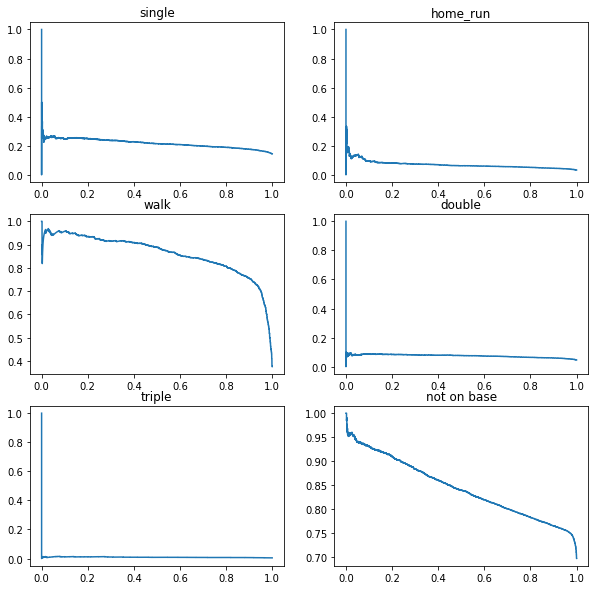

In [117]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for ax_idx, (event, idx) in enumerate(target_events.items()):
    p, r, t = precision_recall_curve(y_all[:, idx], preds[:, idx])
    axs[ax_idx % 3, 0 if not ax_idx % 2 else 1].plot(r, p)
    axs[ax_idx % 3, 0 if not ax_idx % 2 else 1].set_title(event)

p, r, t = precision_recall_curve(y_all[:, 0], preds[:, 0])
axs[2, 1].plot(r, p)
_ = axs[2, 1].set_title('not on base')

## Defining utility functions

In [78]:
def get_feature_embeddings(X, feature, model):
    input_ = encoder.transform(X)[f'{feature}_input']
    return get_embeddings(input_, model, feature)

def get_embeddings(X, model, feature):
    input_ = model.get_layer(f'{feature}_input').get_output_at(-1)
    encoding = model.get_layer(f'{feature}_embedding').get_output_at(-1)
    return keras.models.Model(inputs=input_, outputs=encoding).predict(X)

## Look at embeddings

In [108]:
target_events

{'double': 2, 'home_run': 4, 'single': 1, 'triple': 3, 'walk': 5}

In [127]:
hybrid_model.get_layer('y').get_weights()[0][-1, 1:]

array([-0.7967448 , -0.22506267, -0.12287888, -0.7526419 , -0.3881004 ],
      dtype=float32)

In [131]:
batter_embeddings.shape, batter_coefs

((420,), -2.2854285)

In [152]:
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
batters = batters.merge(stats, left_on='batter_id', right_on='batter_mlbid')
batters = batters[batters.AB > 100]
batter_embeddings = get_feature_embeddings(batters, 'batter_id', hybrid_model).reshape(-1)
batter_coefs = hybrid_model.get_layer('y').get_weights()[0][-1, 1:].sum()
batters['prob_on_base'] = batter_embeddings * batter_coefs
batters.sort_values('prob_on_base', ascending=False).head(10)

,batter_id,batter_mlbname,batter_mlbid,H,BB,HBP,2B,3B,HR,SF,AB,1B,obp,slg,ops,prob_on_base
396,605361.0,Nick Martini,605361.0,45,21,5.0,9,3,1,1.0,152,40,0.396648,0.467105,0.863753,0.823983
58,500208.0,Yangervis Solarte,500208.0,106,31,3.0,20,0,17,3.0,468,103,0.277228,0.450855,0.728082,0.719827
67,465041.0,Francisco Cervelli,465041.0,86,51,15.0,15,3,12,4.0,332,86,0.378109,0.521084,0.899194,0.710626
235,649557.0,Aledmys Diaz,649557.0,111,23,3.0,26,0,18,4.0,422,103,0.303097,0.537915,0.841012,0.696913
288,596748.0,Maikel Franco,596748.0,117,29,0.0,17,1,22,3.0,433,123,0.313978,0.572748,0.886727,0.687655
102,543281.0,Josh Harrison,543281.0,86,18,5.0,13,1,8,5.0,344,82,0.293011,0.415698,0.708708,0.664868
37,545358.0,Max Stassi,545358.0,50,23,6.0,13,0,8,0.0,221,45,0.316000,0.466063,0.782063,0.647977
270,605119.0,Brian Anderson,605119.0,161,62,16.0,34,4,11,2.0,590,142,0.356716,0.450847,0.807564,0.614495
83,514888.0,Jose Altuve,514888.0,169,55,6.0,29,2,13,1.0,534,155,0.385906,0.507491,0.893397,0.596422
232,576397.0,Jedd Gyorko,576397.0,92,44,3.0,19,1,11,4.0,351,85,0.345771,0.484330,0.830102,0.577069


In [150]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitchers = pitchers.merge(pitching_stats, left_on='pitcher_id', right_on='pitcher_mlbid')
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', hybrid_model).reshape(-1)
pitcher_coefs = model.get_layer('y').get_weights()[0][-2, 0]
pitchers['prob_not_on_base'] = pitcher_embeddings * pitcher_coefs
pitchers[pitchers.IP > 100].sort_values('prob_not_on_base', ascending=False).head(10)

,pitcher_id,player_name,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,prob_not_on_base
248,656427.0,Jack Flaherty,656427.0,151.000000,59,108,56,3.337748,1.105960,0.182091
256,571510.0,Matthew Boyd,571510.0,170.333333,51,146,83,4.385519,1.156556,0.168423
218,544931.0,Stephen Strasburg,544931.0,130.000000,38,118,54,3.738462,1.200000,0.154561
374,607231.0,John Gant,607231.0,114.000000,57,91,44,3.473684,1.298246,0.154234
257,518774.0,Matt Harvey,518774.0,155.000000,37,165,85,4.935484,1.303226,0.152425
239,607625.0,Seth Lugo,607625.0,101.333333,28,81,30,2.664474,1.075658,0.144404
83,518452.0,Chad Bettis,518452.0,120.333333,47,121,67,5.011080,1.396122,0.143543
227,519242.0,Chris Sale,519242.0,158.000000,34,102,37,2.107595,0.860759,0.138272
398,605397.0,Joe Musgrove,605397.0,115.333333,23,113,52,4.057803,1.179191,0.128369
333,453562.0,Jake Arrieta,453562.0,172.666667,57,165,76,3.961390,1.285714,0.125488


In [151]:
pitchers[pitchers.IP < 100].sort_values('prob_not_on_base', ascending=False).head(10)

,pitcher_id,player_name,pitcher_mlbid,IP,BB,H,ER,ERA,WHIP,prob_not_on_base
370,458924.0,Jonny Venters,458924.0,34.333333,16,26,14,3.669903,1.223301,0.425430
135,571561.0,Tony Cingrani,571561.0,22.666667,6,19,12,4.764706,1.102941,0.341970
103,448281.0,Sean Doolittle,448281.0,45.000000,6,21,8,1.600000,0.600000,0.331622
357,519293.0,Will Smith,519293.0,53.000000,15,37,15,2.547170,0.981132,0.270033
3,571710.0,Mychal Givens,571710.0,76.666667,30,61,34,3.991304,1.186957,0.261953
100,608678.0,Dominic Leone,608678.0,24.000000,8,27,12,4.500000,1.458333,0.260724
360,456696.0,David Hernandez,456696.0,64.000000,17,46,18,2.531250,0.984375,0.247358
429,669203.0,Corbin Burnes,669203.0,38.000000,11,27,11,2.605263,1.000000,0.245259
399,424144.0,Oliver Perez,424144.0,32.333333,7,17,5,1.391753,0.742268,0.227501
367,489119.0,Wade Miley,489119.0,80.666667,27,71,23,2.566116,1.214876,0.226652


# Recurrent model

In [158]:
import keras
import keras.backend as K

# LSTM input
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))
def Attention(X):
    # https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf
    W = keras.layers.Dense(K.int_shape(X)[-1], activation='tanh', name='W')
    u = W(X)
    u_w = keras.layers.Dense(1, activation='linear', name='u_w')
    attention = keras.layers.Softmax(1)(u_w(u))
    X_attended = keras.layers.Multiply()([X, attention])
    return Sum(X_attended), attention


categorical_dimmensions = {
    'batter_id': 4,
    'pitcher_id': 2,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = {}
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings[feature] = embedding

X_embeddings = keras.layers.Concatenate(axis=-1)(list(embeddings.values()))
X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.BatchNormalization()(X)
X_lstm = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)(X)
X, attention = Attention(X_lstm)
X = keras.layers.Dense(len(target_events) + 1, activation='softmax', name='y')(X)

X_aux = keras.layers.Dense(32, activation='relu')(X_lstm)
X_aux = keras.layers.BatchNormalization()(X_aux)
X_aux = keras.layers.Dense(32, activation='relu')(X_aux)
X_aux = keras.layers.BatchNormalization()(X_aux)
X_aux = keras.layers.Dense(len(auxillary_targets), name='y_aux')(X_aux)

nonlinear_model = keras.models.Model(
    inputs=[numeric_input] + list(categorical_inputs),
    outputs=[X, X_aux])

In [159]:
nonlinear_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [160]:
nonlinear_model.compile(loss={'y': 'categorical_crossentropy', 'y_aux': 'mse'}, optimizer='adam', loss_weights={'y': 1., 'y_aux': 3.})

In [161]:
L = []
def g():
    while True:
        np.random.shuffle(batches)
        for X, y, y_aux in batches:
            if len(y_aux.shape) != 3:
                L.append(None)
                continue
            yield X, {'y': y, 'y_aux': y_aux}
nonlinear_model.fit_generator(g(), steps_per_epoch=len(batches), epochs=10)

Epoch 1/10
1201/1201 [==============================] - 19s 16ms/step - loss: 2.1478 - y_loss: 1.1236 - y_aux_loss: 0.3414 1s - loss: 2.1741 - y_
Epoch 2/10
1201/1201 [==============================] - 14s 12ms/step - loss: 1.6917 - y_loss: 0.8755 - y_aux_loss: 0.2720
Epoch 3/10
1201/1201 [==============================] - 12s 10ms/step - loss: 1.5806 - y_loss: 0.7869 - y_aux_loss: 0.2646
Epoch 4/10
1201/1201 [==============================] - 12s 10ms/step - loss: 1.5509 - y_loss: 0.7675 - y_aux_loss: 0.2611
Epoch 5/10
1201/1201 [==============================] - 12s 10ms/step - loss: 1.5388 - y_loss: 0.7545 - y_aux_loss: 0.2614
Epoch 6/10
1201/1201 [==============================] - 13s 11ms/step - loss: 1.5132 - y_loss: 0.7435 - y_aux_loss: 0.2566
Epoch 7/10
1201/1201 [==============================] - 13s 11ms/step - loss: 1.4906 - y_loss: 0.7301 - y_aux_loss: 0.2535
Epoch 8/10
1201/1201 [==============================] - 13s 11ms/step - loss: 1.4861 - y_loss: 0.7229 - y_aux_loss: 

In [147]:
len(L)

91

## P/R curves

In [162]:
preds = np.concatenate([nonlinear_model.predict(x)[0] for x, _, _ in batches])
y_all = np.concatenate([y for _, y, _ in batches])

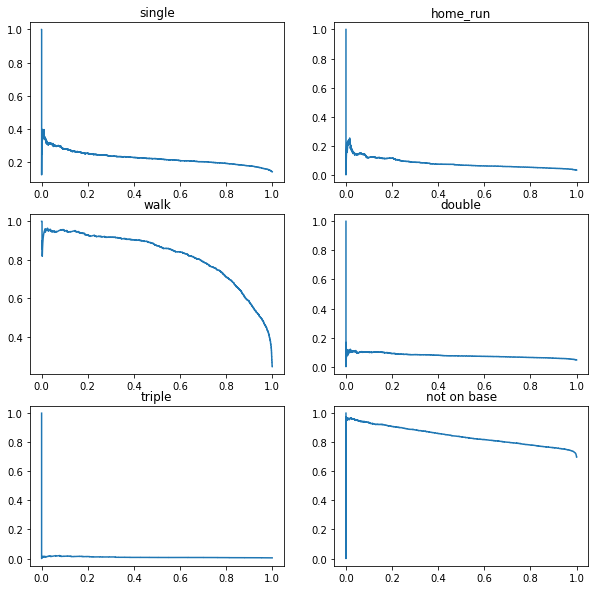

In [163]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for ax_idx, (event, idx) in enumerate(target_events.items()):
    p, r, t = precision_recall_curve(y_all[:, idx], preds[:, idx])
    axs[ax_idx % 3, 0 if not ax_idx % 2 else 1].plot(r, p)
    axs[ax_idx % 3, 0 if not ax_idx % 2 else 1].set_title(event)

p, r, t = precision_recall_curve(y_all[:, 0], preds[:, 0])
axs[2, 1].plot(r, p)
_ = axs[2, 1].set_title('not on base')

# Inspect model

## Pitcher embeddings

In [164]:
pitchers = df[['pitcher_id', 'player_name']].drop_duplicates()
pitchers = pitching_stats.merge(pitchers, left_on='pitcher_mlbid', right_on='pitcher_id')
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher_id', nonlinear_model)
pitchers['x'], pitchers['y'] = zip(*pitcher_embeddings.reshape((-1, 2)))

In [165]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat =  'WHIP'

source = ColumnDataSource(
        data=dict(
            x=pitchers.x,
            y=pitchers.y,
            desc=pitchers.player_name,
            WHIP=pitchers.WHIP
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256[::-1], low=pitchers[lookat].min(), high=pitchers[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)

Loading BokehJS ...

## Look at batter embeddings

In [166]:
from sklearn.manifold import TSNE
batters = df[['batter_id', 'batter_mlbname']].drop_duplicates()
batters = batters.merge(stats, left_on='batter_id', right_on='batter_mlbid')
batters = batters[batters.AB > 100]
batter_embeddings = get_feature_embeddings(batters, 'batter_id', nonlinear_model)
batters['x'], batters['y'] = zip(*TSNE(2).fit_transform(batter_embeddings.reshape((-1, 4))))

In [167]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()

lookat = {
    'Mike Trout': 'red',
    'Christian Yelich': 'green',
    'Bryce Harper': 'orange',
    'Mookie Betts': 'pink',
    'Rhys Hoskins': 'purple',
    'Jean Segura': 'grey'
}

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)


Loading BokehJS ...

In [168]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'slg'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

In [169]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LinearColorMapper, ColorBar
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()


lookat = 'ops'

source = ColumnDataSource(
        data=dict(
            x=batters.x,
            y=batters.y,
            desc=batters.batter_mlbname,
            slg=batters.slg,
            obp=batters.obp,
            ops=batters.ops,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom', 'box_zoom'],
           title="Mouse over the dots")

from bokeh.palettes import Viridis3, Viridis256

transformer = LinearColorMapper(
    palette=Viridis256, low=batters[lookat].min(), high=batters[lookat].max())
p.circle('x', 'y', size=10, source=source, fill_color={'field': lookat, 'transform': transformer})
color_bar = ColorBar(color_mapper=transformer, location=(0, 0))
p.add_layout(color_bar, 'right')
show(p)


Loading BokehJS ...

## Look at attention

In [189]:
A = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=attention)

In [202]:
batch_idx = 7
bx, by, _ = batches[batch_idx]
aa = np.squeeze(A.predict(bx))
bx['numeric_inputs'].shape, aa.shape

((15, 9, 25), (15, 9))

In [203]:
aa

array([[6.34065578e-11, 2.98520167e-11, 5.89386387e-11, 8.33537073e-10,
        3.26671632e-08, 6.46029719e-07, 2.04907730e-03, 3.83778721e-01,
        6.14171565e-01],
       [1.15717618e-11, 7.93750829e-12, 2.43196713e-11, 1.73463480e-10,
        3.12653681e-09, 8.87327545e-08, 1.00414816e-03, 8.73525217e-02,
        9.11643207e-01],
       [3.27893940e-12, 2.88423148e-12, 8.22842402e-12, 4.36878728e-10,
        1.84213350e-05, 2.73034312e-02, 1.40462607e-01, 3.05049777e-01,
        5.27165711e-01],
       [2.64672815e-11, 1.48791743e-11, 7.24724725e-11, 2.35119701e-09,
        3.41100645e-07, 2.92029708e-05, 4.54792427e-03, 1.77452341e-01,
        8.17970157e-01],
       [1.18790264e-11, 7.76944308e-12, 1.78811341e-11, 1.77007867e-10,
        2.57150901e-09, 5.29335148e-06, 1.85791007e-03, 2.06145182e-01,
        7.91991591e-01],
       [3.56983085e-12, 2.97290794e-12, 9.42482637e-12, 8.41859826e-09,
        4.80445524e-05, 5.57544036e-03, 1.86076000e-01, 3.49689960e-01,
        4.5

In [204]:
np.argmax(aa, axis=1)

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8])

In [214]:
p = model.predict(bx)
p[0].shape

(15, 6)

In [206]:
inverse_target_map = {v: k for k, v in target_events.items()}
def inverse_transform(X):
    d = pd.DataFrame(X['numeric_inputs'], columns=numeric_features)
    for f in categorical_features:
        d[f] = encoder.inverse_transform(pd.Series(X[f'{f}_input']), f)
    return d

In [207]:
bx

{'away_team_input': array([[ 9,  9,  9,  9,  9,  9,  9,  9,  9],
        [28, 28, 28, 28, 28, 28, 28, 28, 28],
        [27, 27, 27, 27, 27, 27, 27, 27, 27],
        [26, 26, 26, 26, 26, 26, 26, 26, 26],
        [12, 12, 12, 12, 12, 12, 12, 12, 12],
        [27, 27, 27, 27, 27, 27, 27, 27, 27],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 3,  3,  3,  3,  3,  3,  3,  3,  3],
        [13, 13, 13, 13, 13, 13, 13, 13, 13],
        [29, 29, 29, 29, 29, 29, 29, 29, 29],
        [ 3,  3,  3,  3,  3,  3,  3,  3,  3],
        [12, 12, 12, 12, 12, 12, 12, 12, 12],
        [17, 17, 17, 17, 17, 17, 17, 17, 17]], dtype=int32),
 'batter_id_input': array([[296, 296, 296, 296, 296, 296, 296, 296, 296],
        [225, 225, 225, 225, 225, 225, 225, 225, 225],
        [275, 275, 275, 275, 275, 275, 275, 275, 275],
        [338, 338, 338, 338, 338, 338, 338, 338, 338],
        [242, 242, 242, 242, 242, 242

In [215]:
idx = -6
d = inverse_transform({k: v[idx] for k, v in bx.items()})
d['attention'] = aa[idx].reshape(-1)
d = d.merge(batters[['batter_id', 'batter_mlbname']])
d = d.merge(pitchers[['pitcher_id', 'player_name']])

print('was', inverse_target_map.get(np.argmax(by[idx]), 'not on base event'))
print('predicted', inverse_target_map.get(np.argmax(p[0][idx]), 'not on base event'))

with pd.option_context('display.max_columns', None):
    display(d)

was not on base event
predicted walk


,bat_score,fld_score,balls,strikes,outs_when_up,pitch_number,inning,total_pitch_number,at_bat_number,ax,ay,az,pfx_x,pfx_z,vx0,vy0,vz0,release_speed,release_spin_rate,release_pos_x,release_pos_y,plate_x,plate_z,sz_top,sz_bot,if_fielding_alignment,of_fielding_alignment,inning_topbot,pitch_name,zone,pitcher_id,batter_id,game_type,stand,runner_on_first,runner_on_second,runner_on_third,away_team,home_team,p_throws,attention,batter_mlbname,player_name
0,2,1,0,0,0,1,5,85,37,0,23,-23,0,0,5,-123,-5,84,2097,-2,54,0,2,3,1,Infield shift,Standard,Top,Cutter,5.0,450729.0,459964.0,R,L,0,0,0,OAK,TEX,R,2.120034e-11,Matt Joyce,Doug Fister
1,2,1,0,1,0,2,5,86,37,3,18,-40,0,-1,0,-103,2,71,1938,-2,55,-1,2,3,1,Infield shift,Standard,Top,Curveball,11.0,450729.0,459964.0,R,L,0,0,0,OAK,TEX,R,9.641107e-12,Matt Joyce,Doug Fister
2,2,1,1,1,0,3,5,87,37,-15,23,-27,-1,0,7,-118,-5,81,1743,-2,54,0,1,3,1,Infield shift,Standard,Top,Changeup,13.0,450729.0,459964.0,R,L,0,0,0,OAK,TEX,R,2.580365e-11,Matt Joyce,Doug Fister
3,2,1,1,2,0,4,5,88,37,-13,25,-22,-1,0,9,-126,-1,87,1786,-1,54,0,3,3,1,Infield shift,Standard,Top,Sinker,12.0,450729.0,459964.0,R,L,0,0,0,OAK,TEX,R,5.699625e-10,Matt Joyce,Doug Fister
4,2,1,2,2,0,5,5,89,37,5,20,-42,0,-1,0,-108,0,74,2191,-2,54,-1,2,3,1,Infield shift,Standard,Top,Curveball,13.0,450729.0,459964.0,R,L,0,0,0,OAK,TEX,R,1.388751e-07,Matt Joyce,Doug Fister
5,2,1,2,2,0,6,5,90,37,-14,26,-21,-1,0,9,-128,-5,88,1814,-2,54,0,2,3,1,Infield shift,Standard,Top,Sinker,14.0,450729.0,459964.0,R,L,0,0,0,OAK,TEX,R,3.152797e-04,Matt Joyce,Doug Fister
6,2,1,2,2,0,7,5,91,37,-13,22,-25,-1,0,5,-118,-3,81,1682,-2,54,0,2,3,1,Infield shift,Standard,Top,Changeup,13.0,450729.0,459964.0,R,L,0,0,0,OAK,TEX,R,4.278151e-02,Matt Joyce,Doug Fister
7,2,1,2,2,0,8,5,92,37,-15,26,-18,-1,1,9,-129,-4,89,2047,-2,54,0,2,3,1,Infield shift,Standard,Top,Sinker,3.0,450729.0,459964.0,R,L,0,0,0,OAK,TEX,R,6.499801e-01,Matt Joyce,Doug Fister
8,2,1,2,2,0,9,5,93,37,-17,29,-20,-1,0,7,-130,-6,90,1978,-1,53,0,2,2,1,Infield shift,Standard,Top,Sinker,5.0,450729.0,459964.0,R,L,0,0,0,OAK,TEX,R,3.069229e-01,Matt Joyce,Doug Fister


# counterfactuals

In [217]:
nonlinear_model.inputs

[<tf.Tensor 'numeric_inputs_4:0' shape=(?, ?, 25) dtype=float32>,
 <tf.Tensor 'if_fielding_alignment_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'of_fielding_alignment_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'inning_topbot_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'pitch_name_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'zone_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'pitcher_id_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'batter_id_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'game_type_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'stand_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'runner_on_first_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'runner_on_second_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'runner_on_third_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'away_team_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'home_team_input_4:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import log_loss

def make_loss(model, y_new, x_old, lambda_):
    x_base = {k: v for k, v in x_old.items()}
    x_shape = x_base['numeric_inputs'].shape
    def loss(x):
        x = x.reshape(x_shape)
        x_base['numeric_inputs'] = x
        y_hat = model.predict(x_base).reshape(-1)
        L = lambda_ * log_loss(y_new, y_hat)
        d = np.sum((x - x_old['numeric_inputs']) ** 2)
        return L + d
    return loss

In [ ]:
batch_idx = 0
idx = 0
bx, by, _ = batches[batch_idx]
x_old = {k: np.expand_dims(v[idx], 0) for k, v in bx.items()}
loss = make_loss(
    model,
    np.array([0, 0, 0, 0, 0, 1]),
    x_old,
    2)
minimize(loss, x_old['numeric_inputs'], method='Nelder-Mead')